In [1]:
! apt-get install default-jre
!java -version
! pip install h2o
import h2o
h2o.init()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
openjdk version "11.0.5" 2019-10-15
OpenJDK Runtime Environment (build 11.0.5+10-post-Ubuntu-0ubuntu1.118.04)
OpenJDK 64-Bit Server VM (build 11.0.5+10-post-Ubuntu-0ubuntu1.118.04, mixed mode, sharing)
     |████████████████████████████████| 123.4MB 91kB/s 
  Created wheel for h2o: filename=h2o-3.28.0.1-py2.py3-none-any.whl size=123410554 sha256=5895d07d8bf4191a90b1b6ceef50c5e45b8ee2c9a1523139e3c88c721c153c56
  Stored in directory: /root/.cache/pip/wheels/ff/82/f4/3fe9c895b93c53b25ae44dc44aa54dad571c711f48bc485fe9
Successfully built h2o
Checking whether there is an H2O instance running at h

H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.1
H2O cluster version age:,3 days
H2O cluster name:,H2O_from_python_unknownUser_z2s55l
H2O cluster total nodes:,1
H2O cluster free memory:,3 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


In [2]:
url = "http://h2o-public-test-data.s3.amazonaws.com/smalldata/airlines/allyears2k_headers.zip"
data = h2o.import_file(url)

train,valid,test=data.split_frame([0.8,0.1],seed=7)
print("%d/%d/%d" %(train.nrows,valid.nrows,test.nrows))

Parse progress: |█████████████████████████████████████████████████████████| 100%
35263/4265/4450


In [0]:
y ='ArrDelay'
ignoreFields=['IsArrDelayed','ActualElapsedTime','ArrTime','TailNum']
xWithDep=[i for i in train.names  if i not in ignoreFields]

In [4]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator as dle

m_DLR_def= dle(variable_importances=True) 
%time m_DLR_def.train(xWithDep,y,train,validation_frame=valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
CPU times: user 646 ms, sys: 63.3 ms, total: 710 ms
Wall time: 1min 42s


In [5]:
m_DLR_def.model_performance(valid)


ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 46.22959015216526
RMSE: 6.799234526927664
MAE: 3.360801978926331
RMSLE: NaN
Mean Residual Deviance: 46.22959015216526


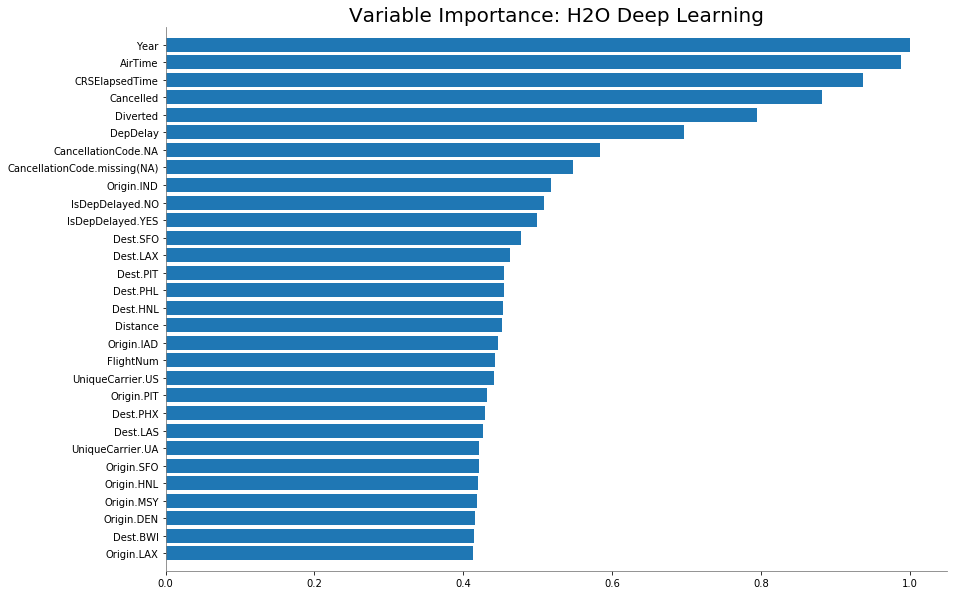

In [6]:
m_DLR_def.varimp_plot(30) # default gives you first 10

Let's increase no of epochs

In [8]:
m_DLR_200_epochs = dle(variable_importances=True, epochs=200)
%time m_DLR_200_epochs.train(xWithDep,y,train,validation_frame=valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
CPU times: user 730 ms, sys: 60.2 ms, total: 790 ms
Wall time: 3min 32s


In [9]:
m_DLR_200_epochs.model_performance(valid)


ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 46.45066075819988
RMSE: 6.815472159593925
MAE: 3.1654259207277655
RMSLE: NaN
Mean Residual Deviance: 46.45066075819988


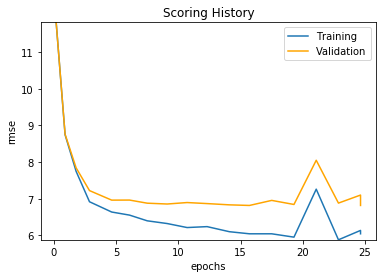

In [10]:
m_DLR_200_epochs.plot()

In [11]:
m_DLR_200_epochs.scoring_history() #training rmse is higher than training_mae which means when it gets it wrong, it gets it wrong

,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2019-12-20 05:00:34,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-12-20 05:00:39,7.088 sec,1197 obs/sec,0.179338,1,6324.0,11.815161,139.598025,8.556201,0.854039,11.810302,139.483233,8.498456,0.840880
2,,2019-12-20 05:00:52,20.369 sec,1828 obs/sec,0.896208,5,31603.0,8.746338,76.498431,6.030981,0.920015,8.759036,76.720712,6.042407,0.912478
3,,2019-12-20 05:01:06,33.417 sec,2159 obs/sec,1.784420,10,62924.0,7.745586,59.994110,4.336962,0.937271,7.841768,61.493332,4.340562,0.929849
4,,2019-12-20 05:01:18,46.463 sec,2494 obs/sec,2.858804,16,100810.0,6.916724,47.841072,4.004959,0.949978,7.221422,52.148938,4.116789,0.940509
5,,2019-12-20 05:01:36,1 min 3.827 sec,2899 obs/sec,4.642969,26,163725.0,6.636002,44.036516,3.457863,0.953956,6.960743,48.451942,3.540988,0.944727
6,,2019-12-20 05:01:49,1 min 17.228 sec,3118 obs/sec,6.077333,34,214305.0,6.551785,42.925885,3.369518,0.955117,6.962553,48.477147,3.492633,0.944698
7,,2019-12-20 05:02:01,1 min 28.878 sec,3341 obs/sec,7.499334,42,264449.0,6.396099,40.910076,3.276470,0.957225,6.877514,47.300205,3.413163,0.946041
8,,2019-12-20 05:02:14,1 min 41.456 sec,3544 obs/sec,9.103253,51,321008.0,6.321567,39.962204,3.026691,0.958216,6.854834,46.988751,3.149662,0.946396
9,,2019-12-20 05:02:26,1 min 53.493 sec,3720 obs/sec,10.706406,60,377540.0,6.212089,38.590045,3.217086,0.959651,6.894813,47.538440,3.444074,0.945769



The distribution of ArrDelay is long-tailed

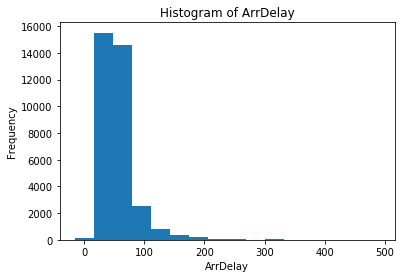

In [13]:
train[y].hist()

it looks like a exponential decay

Let's try a laplace distribution

In [14]:
m_DLR_laplace = dle(
variable_importances=True,
epochs=200,
distribution='laplace'   
)
%time m_DLR_laplace.train(xWithDep,y,train,validation_frame=valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
CPU times: user 929 ms, sys: 55.4 ms, total: 984 ms
Wall time: 4min 26s


In [15]:
m_DLR_laplace.model_performance(valid)


ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 45.672469307487646
RMSE: 6.758140965345991
MAE: 2.963776008094258
RMSLE: NaN
Mean Residual Deviance: 2.963776008094258


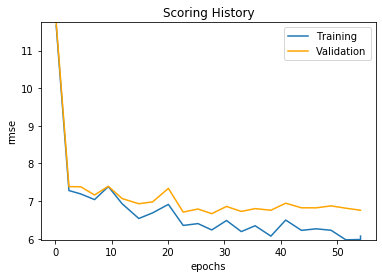

In [17]:
m_DLR_laplace.plot()

This is fairly better